In [8]:
import jax
import jax.numpy as np
from scipy.optimize import root, root_scalar, fsolve
import matplotlib.pyplot as plt
from opyrability import AIS2AOS_map, create_grid
from jax import jacrev, jit, vmap
import cyipopt
import pandas as pd
from jaxopt import ScipyRootFinding, Broyden
from opyrability import implicit_map as imap
import time

In [9]:
from jax.config import config
config.update("jax_enable_x64", True)

In [10]:
# ---------------------------- Set I of parameters -------------------------- #
# Values from Ray (1982) applicable for CSTR Model 1 
#                            from Subramanian (2003)

beta_1    = 0.35
xi_1      = 1.00
gamma_1   = 20.00
phi_1     = 0.11
sigma_s_1 = 0.44
sigma_b_1 = 0.06
q0_1      = 1.00
qc_1      = 1.00
x10_1     = 1.00
x20_1     = 0.00
x30_1     = -0.05


# ---------------------------- Set II of parameters ------------------------- #
# Values from Luyben (1993) applicable for CSTR Model 1 
#                            from Subramanian (2003)

def findA(E,k):
    R,T = 1.99, 599.67
    
    
    return k / np.exp(-E/(R*T))

E1, E2 = 30000, 15000
k1, k2 = 0.5, 0.05

Aa      =  findA(E1,k1)
Ab      =  findA(E2, k2)
beta    = 1.33
xi      = 0.6
gamma   = 25.18
phi     = 19.26
sigma_s = 91.42
sigma_b = 11.43
q0      = 1.00
x10     = 1.00
x20     = -0.12
x30     = - 0.12
qc      = 6.56
# I had to go to Luyben '93 to find these (original source).
dH1     = 20000
dH2     = 20000
eta1    = E1/E2
eta2    = dH1/dH2
Tr      = 599.67
Tc0     = 529.67

# x40, phi2 values were not given but they can be calculated.
x40     =  (Tc0 - Tr)/ Tr
phi2    = (Ab * np.exp(-gamma*(eta1 - 1 ))) / Aa


In [11]:
def cstr(x, AIS):
    
    beta_1    = 0.35
    xi_1      = 1.00
    gamma_1   = 20.00
    phi_1     = 0.11
    sigma_s_1 = 0.44
    sigma_b_1 = 0.06
    q0_1      = 1.00
    qc_1      = 1.00
    x10_1     = 1.00
    x20_1     = 0.00
    x30_1     = -0.05
    
    
    fx2 = np.exp((gamma_1*x)/(1+x)) # f(x2) Appendix B.1
    
    # Equation B.5 broken into terms
    A   = q0_1*(x20_1 - x)

    B   = (beta_1*phi_1*fx2*AIS[1]*q0_1*x10_1) / (q0_1 + phi_1*fx2*AIS[1])

    C   = (((sigma_s_1*AIS[1] + sigma_b_1)*AIS[0]*qc_1) /
         (qc_1*AIS[0] + xi_1*(sigma_s_1*AIS[1] + sigma_b_1)))

    D   = (x - x30_1)

    Eqn = A + B - (C*D)
    Eqn = Eqn.astype(float)
    return Eqn

In [12]:
def cstr_equation(Temp_dimensionless, AIS):
    return cstr(Temp_dimensionless, AIS)

In [13]:
rtol=1e-6

In [14]:
# Using JaxOPT (Differentiable Root-finding from Google)
cstr_solver = Broyden(cstr_equation, tol=rtol, maxls=1000, jit=True)
# Other option is to use the Scipy.optimize.root wrapper written by Google:
# cstr_solver = ScipyRootFinding(method="hybr",
#                                optimality_fun=cstr_equation,
#                                jit=True,
#                                use_jacrev=True, tol=rtol,
#                                options={'ftol': rtol, 'xtol': xtol, 
#                                         "factor": 1.0})

Models for Operability analysis (AIS-AOS maps)

In [15]:
def m_jax(u):
        # 1st CSTR
        initial_estimate = np.array([0.1])
        solution = cstr_solver.run(initial_estimate, AIS=u)
        
        # This line avoids memory leak in JaxOpt. 
        # See https://github.com/google/jaxopt/issues/380 and
        # https://github.com/google/jaxopt/issues/548. Works well. :)
        jax.clear_caches()
        
        
        # This is the equivalent of a if statement (control flow), Jax-compatible.
        def true_fun(_):
            
            initial_estimate = np.array([0.25])
            solution_corrected = cstr_solver.run(initial_estimate, AIS=u)
            return solution_corrected
        
        def false_fun(_):
            return solution
        
        condition = cstr(solution.params, u)[0] > rtol
        solution = jax.lax.cond(condition, true_fun, false_fun, None)
        
       
        # Calculating Outputs from the nonlinear equation results.
        Temp_dimensionless = solution.params # x(2) 
        
        fx1 = np.exp((gamma_1*Temp_dimensionless)/(1 + Temp_dimensionless))
        
        xA_dimensionless = ((q0_1*x10_1) / (q0_1 + phi_1*fx1*u[1])) # Equation B.6 (x1)
        
        conversion = 1 - xA_dimensionless 
        
        # Jacket temperature (optional variable).
        # jacket_temp = (qc_1*u[0]*x30_1 + xi_1*(sigma_s_1*u[1] + sigma_b_1)*xA_dimensionless)/ \
        #     (qc_1*u[0] +  xi_1*(sigma_s_1*u[1] + sigma_b_1))
        
              
        
        return np.array([Temp_dimensionless, conversion]).reshape(2,)

 Brute force enumeration using JAX's VMAP

In [16]:
AIS_bound =  np.array([[0.25,  1.20],
                        [0.50, 1.20]])

AIS_resolution = [100, 100]

In [17]:
u_values = create_grid(AIS_bound, AIS_resolution).reshape(AIS_resolution[0]**2, -1)

In [18]:
vectorized_map = vmap(m_jax)

In [19]:
start_time = time.time()
results = vectorized_map(u_values)
elapsed_time = time.time() - start_time
print(f"Elapsed time: {elapsed_time:.2f} seconds")

Temps = results[:, 0]
Conversions = results[:, 1]

Elapsed time: 76.92 seconds


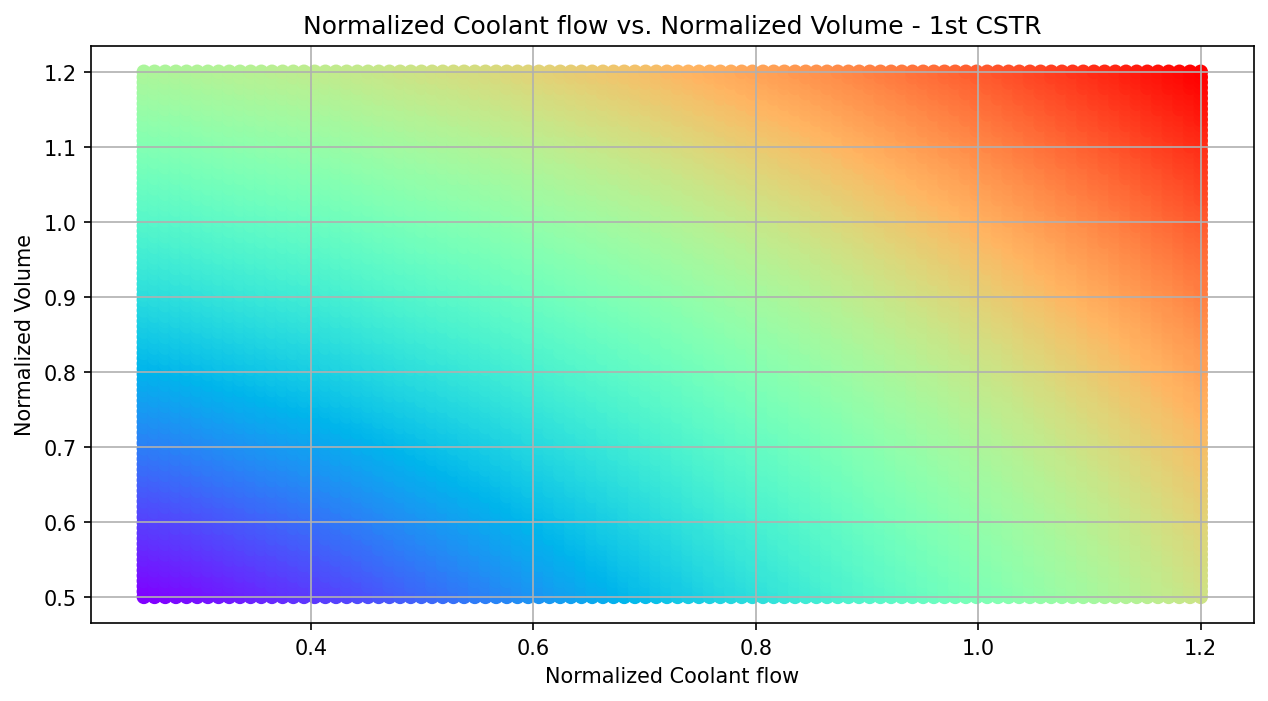

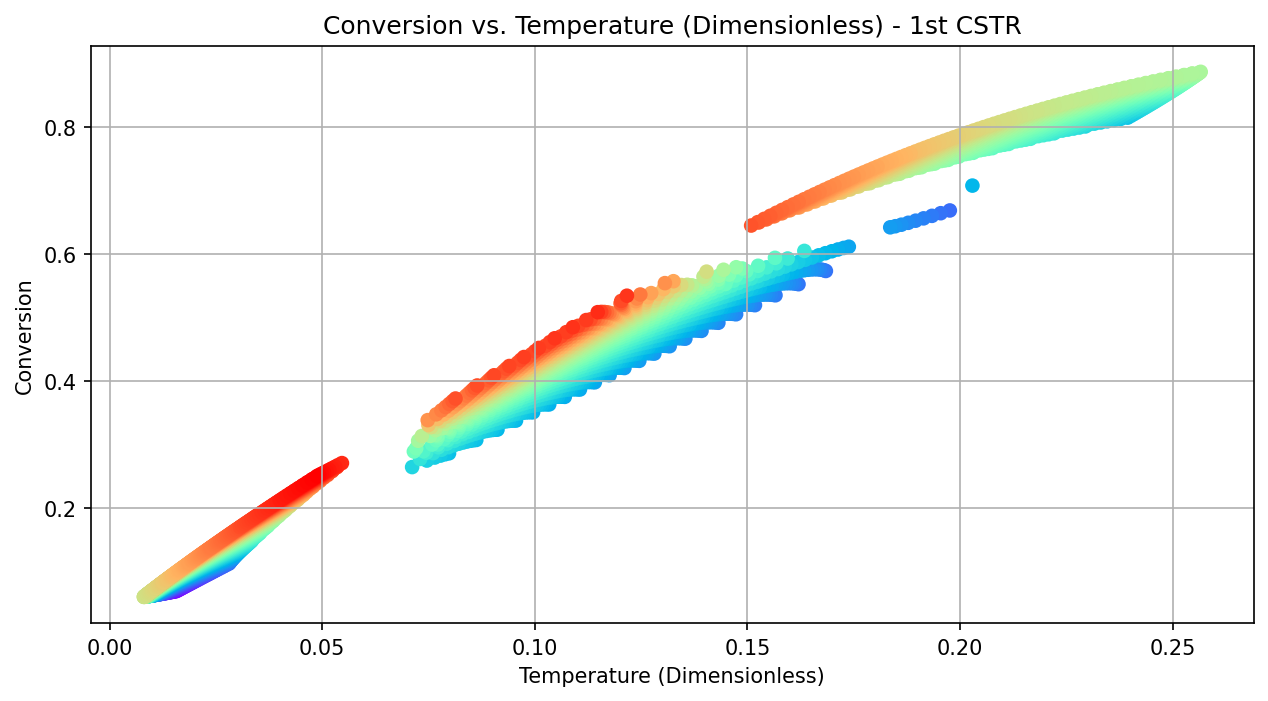

In [20]:
plt.figure(figsize=(10, 5))
plt.scatter(u_values[:,0], u_values[:,1], marker='o', linestyle='-',
            c=np.sqrt(u_values[:, 0]**2 + u_values[:, 1]**2), cmap='rainbow')

plt.xlabel("Normalized Coolant flow")
plt.ylabel("Normalized Volume")
plt.grid(True)
plt.title("Normalized Coolant flow vs. Normalized Volume - 1st CSTR")
plt.show()

# Plotting AOS
plt.figure(figsize=(10, 5))
plt.scatter(Temps, Conversions, marker='o', linestyle='-',
            c=np.sqrt(u_values[:, 0]**2 + u_values[:, 1]**2) , cmap='rainbow')

plt.xlabel("Temperature (Dimensionless)")
plt.ylabel("Conversion")
plt.grid(True)
plt.title("Conversion vs. Temperature (Dimensionless) - 1st CSTR")
plt.show()

In [25]:
def F(input_vector, output_vector):
    
        # 1st CSTR in implicit form F(u,y) = 0
        T_adim, Conv =  output_vector
        u = input_vector
        
        # 1st CSTR
        initial_estimate = np.array([0.1])
        solution = cstr_solver.run(initial_estimate, AIS=u)
        
        # This line avoids memory leak in JaxOpt. 
        # See https://github.com/google/jaxopt/issues/380 and
        # https://github.com/google/jaxopt/issues/548. Works well. :)
        jax.clear_caches()
        
        
        # This is the equivalent of a if statment (control flow), Jax-compatible.
        def true_fun(_):
            initial_estimate = np.array([0.25])
            solution_corrected = cstr_solver.run(initial_estimate, AIS=u)
            return solution_corrected
        
        def false_fun(_):
            return solution
        
        condition = cstr(solution.params, u)[0] > rtol
        solution = jax.lax.cond(condition, true_fun, false_fun, None)
        
       
            
        # Calculating Outputs from the nonlinear equation results.
        Temp_dimensionless = solution.params # x(2) 
        
        fx1 = np.exp((gamma_1*Temp_dimensionless)/(1 + Temp_dimensionless))
        
        xA_dimensionless = ((q0_1*x10_1) / (q0_1 + phi_1*fx1*u[1])) # Equation B.6 (x1)
        
        conversion = 1 - xA_dimensionless 
        
        LHS1 = T_adim - Temp_dimensionless
        LHS2 = Conv - conversion
        

        
        return np.array([LHS1, LHS2]).reshape(2,)

In [26]:
from jax import jacfwd,jacrev


dFdL  = jacrev(F, 0)
dFdz  = jacrev(F, 1)
dFdB  = jacrev(F, 2)
dFdX  = jacrev(F, 3)

In [27]:
def fprime(i1, i2, o1, o2):
    """returns
    di1/do1  di2/do1
    di1/do2  di2/do2

    From:
    0 = dF/di di/do + dF/do

    di/do = -dF/do / dF/di
    or
    di/do = -(dF/di)^-1 @ dF/do

    """
    dFdo = np.array([dFdB(i1, i2, o1, o2), dFdX(i1, i2, o1, o2)]).squeeze()
    dFdi = np.array([dFdL(i1, i2, o1, o2),  dFdz(i1, i2, o1, o2)]).squeeze()

    di_do = -dFdo @ np.linalg.pinv(dFdi)
    
    return di_do

In [37]:
dpath = u_values[:1] - u_values[-1:]
print(dpath)

[[-0.95 -0.7 ]]


In [38]:
i1, i2, o1, o2 =  *u_values[0], *results[0]

In [39]:
# starting point
inp = [[i1, i2]]
out = [[o1, o2]]

# Now iterate on each point and update the variables.
for i, h in enumerate(dpath):

    # h is the step, do1, do2
    #
    # fp is di1/do1, di1/do2
    #       di2/do1, di2/do2
    #
    # in this form, it is y' = f(y, t)
    # where (i1, i2) are the dependent y terms),
    # and (o1, o2) are the independent t vars
    
    do1, do2 = h
    
    # k1 = f'(y, t)
    k1 = fprime(i1, i2, o1, o2)
    hk11, hk12 = np.sum(k1 * h[:, None], axis=0)

    # k2 = f'(y + h * k1 / 2, t + h/2)
    k2 = fprime(i1 + hk11 / 2, i2 + hk12 / 2, o1 + do1 / 2, o2 + do2 / 2)
    hk21, hk22 = np.sum(k2 * h[:, None], axis=0)

    # k3 = f'(y + h k2 / 2, t + h / 2)
    k3 = fprime(i1 + hk21 / 2, i2 + hk22 / 2, o1 + do1 / 2, o2 + do2 / 2)
    hk31, hk32 = np.sum(k3 * h[:, None], axis=0)

    # k4 = f'(y + h * k3, t + h)
    k4 = fprime(i1 + hk31, i2 + hk32, o1 + do1, o2 + do2)

    # dy = h / 6 * (k1 + 2 k2 + 2 k3 + k4) 
    dy = h[:, None] / 6 * (k1 + 2 * k2 + 2 * k3 + k4)

    di1, di2 = np.sum(dy, axis=0)
    
    o1 = o1 + h[0]
    o2 = o2 + h[1]
            
    i1 = i1 + di1
    i2 = i2 + di2

    # Raise Exception: If the solution is not essentially zero, tune it
    if not (np.all(np.abs(F(i1, i2, o1, o2)) < 1e-2)):
        print(i1, i2, o1, o2, F(i1, i2, o1, o2))
        ## Added fine tuning for solution. Tested and working
        sol = root(lambda X, benz, conv: F(X[0], X[1], benz, conv), [i1,  i2],
           args=(o1, o2))
        i1, i2  = sol.x[0], sol.x[1]
        # Just printing to check if it actually found the zero.
        print(i, sol.success, sol.fun, i1,i2)
        
    
    inp += [[i1, i2]]
    out += [[o1, o2]]

inp = np.array(inp)
out = np.array(out)

TypeError: F() takes 2 positional arguments but 4 were given